In [1]:
using Turing
using StatsPlots
using Random
using Turing.RandomMeasures
using Plots
using Distributions
using DataFrames;

Random.seed!(12);

Precompiling Turing
        Info Given Turing was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Turing
[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0].


In [2]:
# Plotting
theme(:dark)

#### Hyperparameters

In [3]:
# Success parameter for Truth-value Bernoulli
pi = rand(Beta(1,1))
# Success parameter for predicability Bernoulli
theta = rand(Beta(1,1))
# Concentration parameter for Dirichlet
alpha = 10.0;
# Number of objects
IMax = 4
# Number of predicates 
JMax = 4
# Number of object types
ZMax = 2;

#### Priors

In [4]:
# Random measure for CRP
rpm = DirichletProcess(alpha)
# Latent type assignments of objects
z = tzeros(Int, IMax)
for i in 1:IMax
  # Number of clusters.
  K = minimum([maximum(z), ZMax-1])
  nk = Vector{Int}(map(k -> sum(z .== k), 1:K))
  # Draw the latent assignment.
  z[i] = rand(ChineseRestaurantProcess(rpm, nk))
end

In [5]:
# Truth-value prior
R = rand(Bernoulli(theta), maximum(z), JMax);

In [6]:
# Truth-value prior
T = zeros(Real, IMax, JMax)
for i in 1:IMax
  for j in 1:JMax
    # Only assign truth values to predicable i,j pairs
    if R[z[i],j] == 1
      T[i,j] = Int(rand(Bernoulli(pi)))
    else
      # Could make this an error signal like NaN
      T[i,j] = 0
    end
  end
end

#### Observations

In [7]:
# Observation matrix
D = zeros(Real, IMax, JMax)
for i in 1:IMax
  for j in 1:JMax
    # Only assign truth values to predicable i,j pairs
    if R[z[i],j] == 1
      D[i,j] = T[i,j]
    else
      # Could make this an error signal like NaN
      D[i,j] = -1
    end
  end
end

In [9]:
z

4-element Vector{Int64}:
 1
 2
 2
 2

#### Model

In [10]:
@model function genmodel(D)
  # Success parameter for Truth-value Bernoulli
  pi ~ Beta(1,1)
  # Success parameter for predicability Bernoulli
  theta ~ Beta(1,1)
  # Concentration parameter for Dirichlet
  alpha = 10.0;
  # Number of objects
  IMax = size(D)[1]
  # Number of predicates 
  JMax = size(D)[2]
  # p(z), latent type assignments of objects
  z = [1,2,2,2]#tzeros(Int, IMax)
  # Random measure for CRP
  # rpm = DirichletProcess(alpha)
  # for i in 1:IMax
  #   # Number of clusters.
  #   K = maximum(z)
  #   nk = Vector{Int}(map(k -> sum(z .== k), 1:K))
  #   # Draw the latent assignment.
  #   z[i] ~ ChineseRestaurantProcess(rpm, nk)
  # end
  # p(R|z)
  R = zeros(Real, maximum(z), JMax)
  for i in 1:maximum(z)
    for j in 1:JMax
      R[i,j] ~ Bernoulli(theta)
    end
  end
  # p(T|R)
  T = zeros(Real, IMax, JMax)
  for i in 1:IMax
    for j in 1:JMax
      # Only assign truth values to predicable i,j pairs
      if R[z[i],j] == 1
        T[i,j] ~ Bernoulli(pi)
      else
        # Could make this an error signal like NaN
        T[i,j] ~ Bernoulli(0)
      end
    end
  end
  for i in 1:IMax
    for j in 1:JMax
      if R[z[i],j] == 1
        D[i,j] ~ Bernoulli(T[i,j])
      else
        D[i,j] ~ Bernoulli(1)*-1
      end
    end
  end
end

genmodel (generic function with 2 methods)

In [11]:
c1 = sample(genmodel(D), SMC(), 1000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×28×1 Array{Float64, 3}):

Log evidence      = -2.207464931242007
Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 11.44 seconds
Compute duration  = 11.44 seconds
parameters        = pi, theta, R[1,1], R[1,2], R[1,3], R[1,4], R[2,1], R[2,2], R[2,3], R[2,4], T[1,1], T[1,2], T[1,3], T[1,4], T[2,1], T[2,2], T[2,3], T[2,4], T[3,1], T[3,2], T[3,3], T[3,4], T[4,1], T[4,2], T[4,3], T[4,4]
internals         = lp, weight

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          pi    0.5246    0.2805    0.0206   186.6847   131.8349    1.0042     ⋯
       theta    0.1561    0.1408    0.0098   203.4162   176.7036    1.0038     ⋯
      R[1,1]    0.0000    0.0000       NaN        NaN        NaN       NaN     ⋯
      R[1,2]    0.0000    0.0000       NaN        NaN        NaN       NaN     ⋯
      R

In [12]:
df = DataFrame(c1);

In [13]:
Z_post_df = select(df, r"z");

In [14]:
T_post_df = select(df, r"T");

In [15]:
R_post_df = select(df, r"R");

In [20]:
T_post = zeros(Real, IMax, JMax)
R_post = zeros(Real, 2, JMax)
z_post = zeros(Real, IMax)

4-element Vector{Real}:
 0
 0
 0
 0

In [21]:
for i in 1:IMax
  for j in 1:JMax
    col_name = Symbol("T[", i, ",", j, "]")
    mu = mean(T_post_df[:, col_name])
    T_post[i,j] = mu
  end
end

In [22]:
for i in 1:2
  for j in 1:JMax
    col_name = Symbol("R[", i, ",", j, "]")
    mu = mean(R_post_df[:, col_name])
    R_post[i,j] = mu
  end
end

In [25]:
z_post

4-element Vector{Real}:
 0
 0
 0
 0

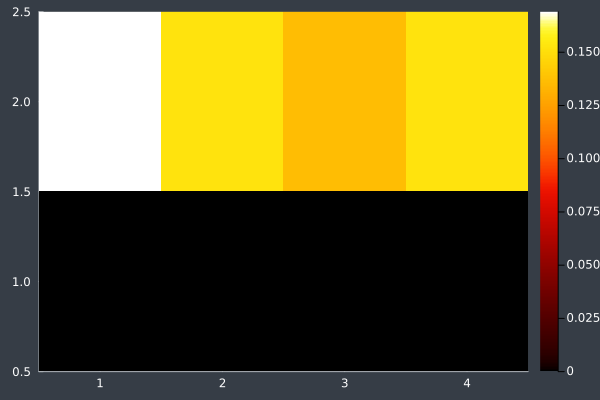

In [29]:
heatmap(R_post)

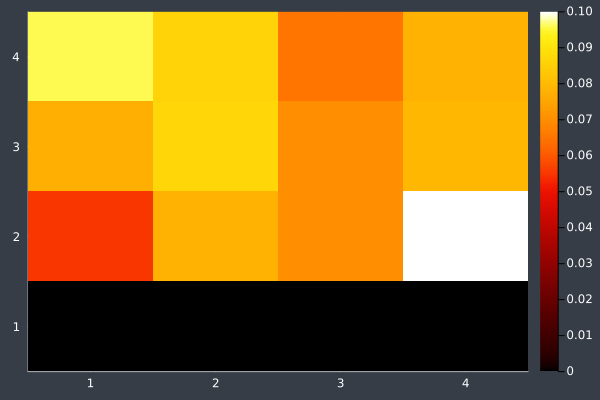

In [27]:
heatmap(T_post)

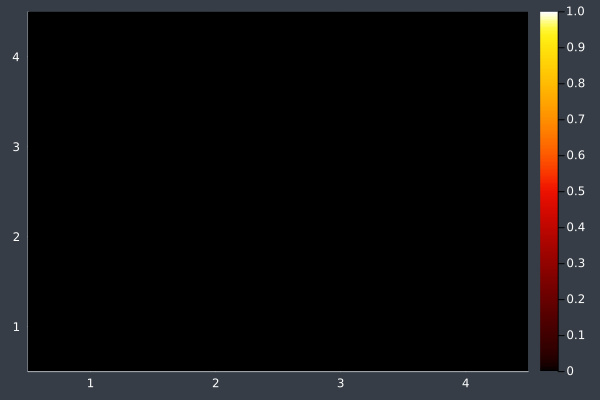

In [28]:
heatmap(T)